# 04-Logistic-regression.ipynb

#### 1. Train and evaluate a logistic regression model (without any regularization penalty="none" and without any hyperparameters tuning).

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [18]:
# creating x and y

train_features = np.load('train_features.npz')['features']
train_labels = np.load('labelled_train_features.npz')['labels']
valid_features = np.load('valid_features.npz')['features']
valid_labels = np.load('labelled_valid_features.npz')['labels']
test_features = np.load('test_features.npz')['features']
test_labels = np.load('labelled_test_features.npz')['labels']

labels_df_train = pd.DataFrame(train_labels) 
labels_df_valid = pd.DataFrame(valid_labels) 
labels_df_test = pd.DataFrame(test_labels) 
y_tr = labels_df_train.values.ravel()
y_val = labels_df_valid.values.ravel()
y_te = labels_df_test.values.ravel()

features_df_train = pd.DataFrame(train_features) 
features_df_valid = pd.DataFrame(valid_features) 
features_df_test = pd.DataFrame(test_features)
X_tr = features_df_train.values
X_val = features_df_valid.values
X_te = features_df_test.values


In [19]:
# Create the multiclass estimator 
logreg = make_pipeline(
    StandardScaler(), 
    LogisticRegression(multi_class='multinomial', solver='saga'))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) 

Accuracy: 0.260


/Applications/anaconda3/envs/adsml/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Observation: <br>
Very poor result. The model should be regularised.

#### 2. Get the model coefficients using the coef_ attribute of your estimator and visualize them using a heatmap.

#### 2.1 getting the largest coefficients per category

In [20]:
# getting the coefficients
coefficients = logreg.named_steps['logisticregression'].coef_
print('shape :', coefficients.shape)
print('coefs of the first category: ', coefficients[0])

n_classes = coefficients.shape[0] 
n_features = coefficients.shape[1] 

shape : (6, 1280)
coefs of the first category:  [ 0.00641342  0.01763083 -0.0399665  ... -0.03655945 -0.03576523
 -0.02985752]


Note: <br>
To understand which features play role in defining given category, we need to consider both those that correlate positively and negatively, it's the strength that matters not the sign. Those that are bvery strong and negative also convey an important message. For this reason, I will consider below their absolute value to choose the top 5.

In [21]:
# Find the largest 5 coefficients (by magnitude) for each category
largest_coefficients = []
for class_coeffs in coefficients:  
    largest_indices = np.argsort(np.abs(class_coeffs))[::-1][:5]  # Sort by absolute value and get top 5 indices
    largest_coefficients.append(largest_indices)

# Print the results
for i, indices in enumerate(largest_coefficients):
    category = "Category {}".format(i)
    print(category)
    for idx in indices:
        print("Index: {}, Coefficient: {:.4f}".format(idx, coefficients[i][idx]))
    print()

Category 0
Index: 341, Coefficient: 0.1213
Index: 529, Coefficient: -0.1193
Index: 1240, Coefficient: -0.1157
Index: 1140, Coefficient: 0.1081
Index: 70, Coefficient: 0.1061

Category 1
Index: 741, Coefficient: 0.2125
Index: 214, Coefficient: 0.1278
Index: 1024, Coefficient: 0.1276
Index: 1047, Coefficient: 0.1164
Index: 1062, Coefficient: 0.1101

Category 2
Index: 24, Coefficient: 0.1410
Index: 845, Coefficient: 0.1154
Index: 863, Coefficient: 0.1092
Index: 1214, Coefficient: 0.1081
Index: 963, Coefficient: -0.1065

Category 3
Index: 1157, Coefficient: 0.1576
Index: 325, Coefficient: 0.1283
Index: 1163, Coefficient: 0.0949
Index: 437, Coefficient: 0.0941
Index: 864, Coefficient: 0.0915

Category 4
Index: 880, Coefficient: 0.1432
Index: 726, Coefficient: 0.1271
Index: 1163, Coefficient: 0.1089
Index: 1092, Coefficient: 0.1073
Index: 907, Coefficient: 0.1066

Category 5
Index: 380, Coefficient: 0.1056
Index: 374, Coefficient: 0.0907
Index: 484, Coefficient: 0.0846
Index: 367, Coefficien

#### 2.2 Heatmap

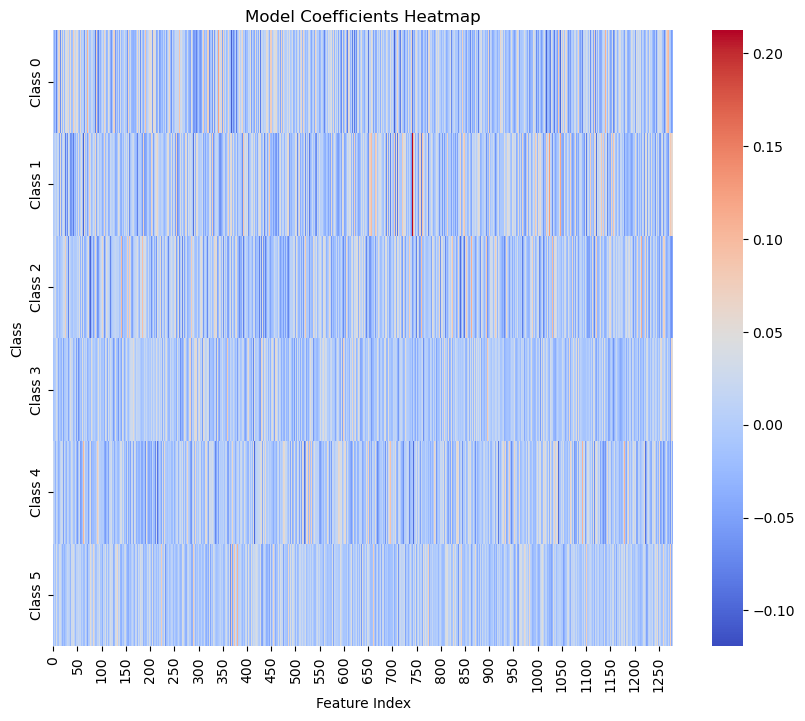

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(coefficients, ax=ax, cmap='coolwarm')

# Adjust x-axis ticks to display every 50th label
ax.set_xticks(range(0, len(coefficients[0]), 50))
ax.set_xticklabels(range(0, len(coefficients[0]), 50))

# Set y-axis tick labels
ax.set_yticklabels(['Class {}'.format(i) for i in range(coefficients.shape[0])])


plt.title('Model Coefficients Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Class')
plt.show()


Observation: <br>
The heatmap is predominantly red-ish meaning most offeatures coefficients tent to be positive. Dark colours (blue and red) indicating high absolute coefficient are quite uniformely distributed accross all features within each class with a few exceptions. 

#### 4. Are these results consistent with your observations during the data exploration in the last question of Task 1?

Answer: <br>
In Task 1 the most important features were: 165,261,59,1120,257 and they repeated accross categories. Here no coefficient index (corresponding to a given feature) repeats. With 1280 features and no regularisation, there necessarily must be a collinearity problem and the model performs poorly ( see its low accuracy above), so at this point I would not try to compare the two results.


#### 5. Set an “l2” regularization and tune the regularization strength parameter of the model with cross-validated grid-search.

##### 5.1 Merging training and validation sets 

In [23]:
# y
labels_df_train_valid = pd.concat([labels_df_train, labels_df_valid])
labels_df_train_valid.reset_index(drop=True, inplace=True)
y_tr_val = labels_df_train_valid.values.ravel()

print('Shape of labels_tr: ',labels_df_train.shape)
print('Shape of labels_val: ',labels_df_valid.shape)
print('Shape of labels_tr_val: ',labels_df_train_valid.shape)

Shape of labels_tr:  (280, 1)
Shape of labels_val:  (139, 1)
Shape of labels_tr_val:  (419, 1)


In [24]:
# x
features_df_train_valid = pd.concat([features_df_train, features_df_valid])
features_df_train_valid.reset_index(drop=True, inplace=True)

X_tr_val = features_df_train_valid.values

print('Shape of features_df_train: ',features_df_train.shape)
print('Shape of features_df_valid: ',features_df_valid.shape)
print('Shape of features_df_train_valid: ',features_df_train_valid.shape)

Shape of features_df_train:  (280, 1280)
Shape of features_df_valid:  (139, 1280)
Shape of features_df_train_valid:  (419, 1280)


##### 5.2 tuning the regularization strength (using L2) with cross-validated grid-search

In [25]:
# Creating new pipeline, this time with L2 regularization

logreg2 = make_pipeline(
    StandardScaler(), 
    LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs'))

# Building cross-validation object

#grid = {"logisticregression__C": np.logspace(-4, 4, num=10),
grid = {"logisticregression__C": np.logspace(-6, -2, num=20),
       "logisticregression__max_iter": [500]}  

grid_cv = GridSearchCV(logreg2, grid, cv=5, return_train_score=True,verbose=1, n_jobs=2)

Parameters selected:<br>
* C values are on a log scale between 10^(-6) and 10^(-2) 
* cross-validation strategy= 5 folds 

In [26]:
# Fit estimator

grid_cv.fit(X_tr_val, y_tr_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-06, 1.62377674e-06, 2.63665090e-06, 4.28133240e-06,
       6.95192796e-06, 1.12883789e-05, 1.83298071e-05, 2.97635144e-05,
       4.83293024e-05, 7.84759970e-05, 1.27427499e-04, 2.06913808e-04,
       3.35981829e-04, 5.45559478e-04, 8.85866790e-04, 1.43844989e-03,
       2.33572147e-03, 3.79269019e-03, 6.15848211e-03, 1.00000000e-02]),
                         'logisticregression__max_iter': [500]},
             return_train_score=True, verbose=1)

In [27]:
#grid_cv.cv_results_.keys()

In [28]:
# Get the results with "cv_results_"
grid_cv.cv_results_.keys()

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)
cv_results.columns


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_logisticregression__max_iter',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [29]:
# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_logisticregression__C",
]
results= cv_results[cols].sort_values("mean_test_score", ascending=False)
results.head(10)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logisticregression__C
14,0.339530,0.198028,0.656903,0.022191,0.000886
12,0.339501,0.178317,0.539995,0.022032,0.000336
15,0.337120,0.190151,0.736249,0.026963,0.001438
13,0.334854,0.204558,0.595473,0.014725,0.000546
16,0.322748,0.168637,0.821567,0.034120,0.002336
11,0.322719,0.166135,0.504801,0.025710,0.000207
17,0.315605,0.159468,0.911674,0.024704,0.003793
6,0.308204,0.094182,0.338323,0.016518,0.000018
7,0.305881,0.105136,0.338314,0.011801,0.00003
18,0.301262,0.152358,0.969558,0.013278,0.006158


Observation: <br>
C contolling the weight of the loss function, it's very low values imply that the penalization term has a large impact on the overall loss value. (In the above table "test" refers to the validation fold.)

With a very strong regularisation (C close to zero), we improve the score from 0.12 to 0.38. It's a big improvement but still not an impressive result. 



##### 5.3. Interpret the results: explain what are the mean_train_score, mean_test_score, std_train_score and std_test_score:
* How are they obtained?
* What do they measure?


1) **mean_train_score** is obtained by avereging scores across all training folds (composed from the merged above train and validation data) during cross-validation and informs how well the model fits the training data. I other words, it's the average value obtained from the white boxes below.

2) **std_train_score** is standard deviation of the training scores obtained during cross-validation across all folds and it measures the variability of the model's performance on the training data (how much the score changes from fold to fold? if alot, the model is not stable)

3) **mean_test_score, std_test_score** - the same as above but relative to the validation data (red boxes) 

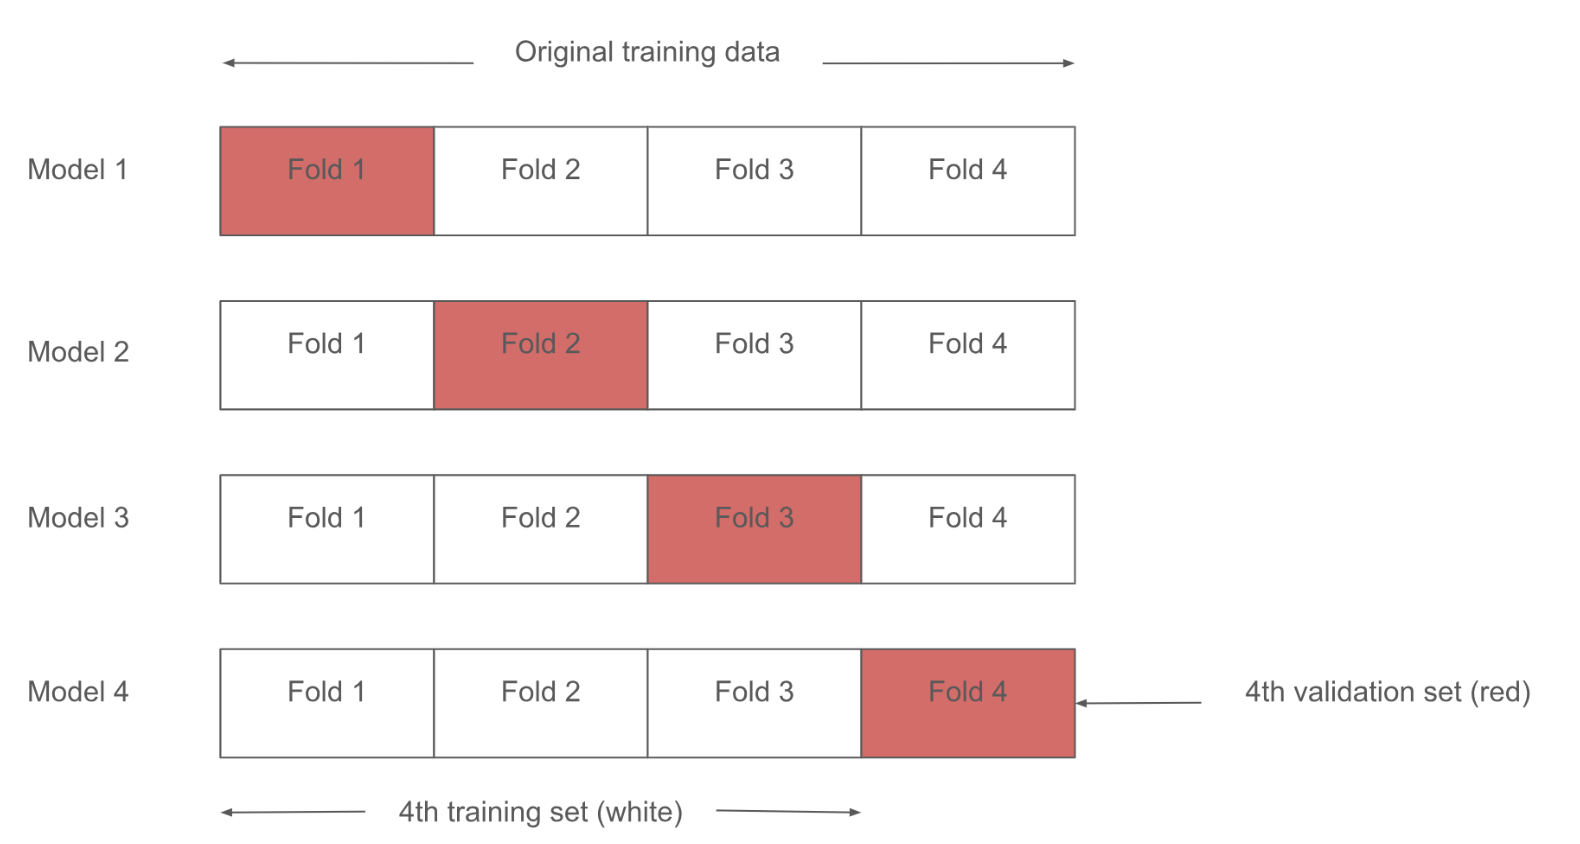



##### 5.4 Do the training and validation curves indicate overfitting?

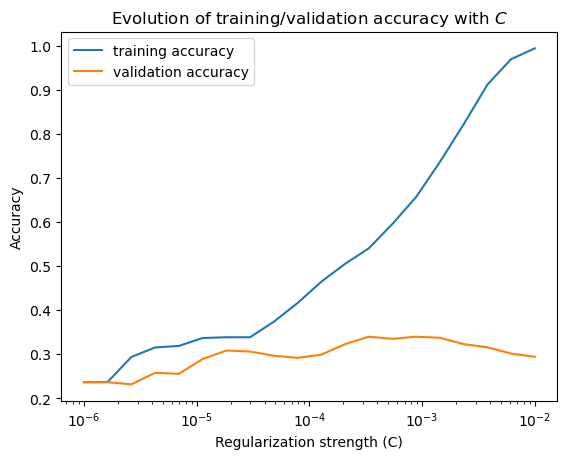

In [30]:
%matplotlib inline


# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_logisticregression__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_logisticregression__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()

The systematic higher performance on the train data with respect to the validation data indicates overfitting. With very high regularisation strength, the two curves overlap (but the model's performance is not the best), decreasing its strength to a certain level (C of 10^(-3.8)) allows obtaining the optimal results in terms of the validation score, beyont which (while we weaken regularisation), the descrepancy between the two curves soars indicating significant overfitting and coinsides with the decrease in performance on validation set.

### 5.4 running model with the optimal regularization strength on the test data

In [31]:
bestC =results.iloc[0, -1]
bestC

0.0008858667904100823

In [32]:
logreg3 = make_pipeline(
    StandardScaler(), 
    LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs', C=bestC ))

# Fit it to train data
logreg3.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg3.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) 

Accuracy: 0.280
